In [61]:
import pandas as pd
import numpy as np

### Load the dataset and explore the variables.

In [78]:
data = pd.read_csv('files_for_lab/customer_churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### We will try to predict variable Churn using a logistic regression on variables tenure, SeniorCitizen, MonthlyCharges.

In [79]:
data =  data[['tenure', 'SeniorCitizen', 'MonthlyCharges', 'Churn']]

In [80]:
data = data.drop_duplicates()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6566 entries, 0 to 7042
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          6566 non-null   int64  
 1   SeniorCitizen   6566 non-null   int64  
 2   MonthlyCharges  6566 non-null   float64
 3   Churn           6566 non-null   object 
dtypes: float64(1), int64(2), object(1)
memory usage: 256.5+ KB


In [81]:
# Let's change the churn with numeric values.
data['Churn'] = data['Churn'].replace({'Yes': 1, 'No': 0})

In [82]:
# reset the index
data = data.reset_index(drop=True)

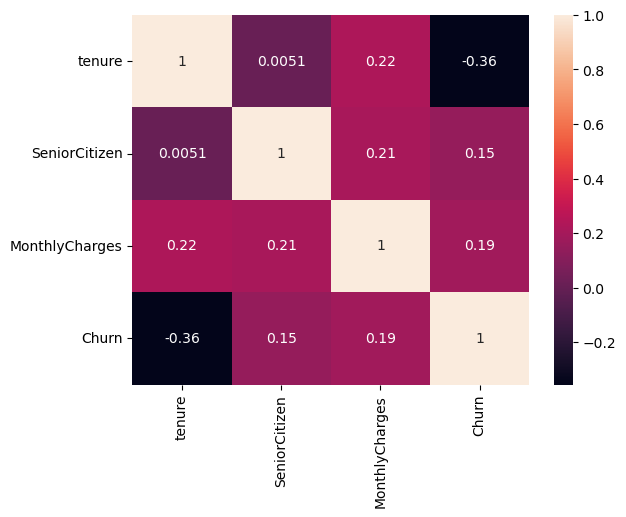

In [83]:
# check correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

data.corr()
sns.heatmap(data.corr(), annot=True)
plt.show()

We have low correlations to start with, not ideal

### Split the Dataset into X ('tenure', 'SeniorCitizen', 'MonthlyCharges') and y ('Churn').

In [84]:
from sklearn.model_selection import train_test_split

y = data['Churn']
X = data.drop('Churn', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_num = X_train.select_dtypes(include=['int64', 'float64'])
X_test_num = X_test.select_dtypes(include=['int64', 'float64'])

Let's scale baby

In [85]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns)

X_train_num_scaled_df.head()

,tenure,SeniorCitizen,MonthlyCharges
0,1.566560,2.225904,-1.391595
1,1.360327,-0.449256,-0.125934
2,-0.495768,-0.449256,0.611942
3,-0.330781,2.225904,0.758834
4,-0.743247,-0.449256,0.082448


### Build the logistic regression model.

In [118]:
from sklearn.linear_model import LogisticRegression

lrclassifier = LogisticRegression(random_state=0 , solver='lbfgs')
lrclassifier.fit(X_train_num_scaled_df, y_train)  
y_pred = lrclassifier.predict(X_test_num_scaled_df)

### Evaluate the model.

In [87]:
# Let's see this in a confusion matrix 
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,y_pred)

array([[852,  64],
       [234, 164]], dtype=int64)

In [119]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score 

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1: {:.2f}'.format(f1_score(y_test, y_pred)))
print('Kappa: {:.2f}'.format(cohen_kappa_score(y_test, y_pred)))

Accuracy: 0.77
Precision: 0.72
Recall: 0.41
F1: 0.52
Kappa: 0.39


In [120]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       916
           1       0.72      0.41      0.52       398

    accuracy                           0.77      1314
   macro avg       0.75      0.67      0.69      1314
weighted avg       0.76      0.77      0.75      1314



### Even a simple model will give us more than 70% accuracy. Why?

In [121]:
# Show sample size of the majority class and minority class
print('Majority class sample size: ', len(y_train[y_train==0]))
print('Minority class sample size: ', len(y_train[y_train==1]))


Majority class sample size:  3883
Minority class sample size:  1369


It would seem we have a problem with the balance of the data, leading to a model biased towards the majority class.

### Synthetic Minority Oversampling TEchnique (SMOTE) is an over sampling technique based on nearest neighbors that adds new points between existing points. 
Apply imblearn.over_sampling.SMOTE to the dataset. 

In [123]:
# Applying SMOTE to generate synthetic samples for the minority class
from imblearn.over_sampling import SMOTE 

smote = SMOTE(k_neighbors=5, random_state=42)
X_train_num_scaled_df_SMOTE, y_train_SMOTE = smote.fit_resample(X_train_num_scaled_df, y_train)

print("Before SMOTE: ", X_train_num_scaled_df.shape)
print("After SMOTE: ", X_train_num_scaled_df_SMOTE.shape)

print("The accuracy of the model in the TEST set is: {:.2f}".format(lr.score(X_test_num_scaled_df, y_test)))


Before SMOTE:  (5252, 3)
After SMOTE:  (7766, 3)
The accuracy of the model in the TEST set is: 0.73


Build and evaluate the logistic regression model. 

In [124]:
lrclassifier_SMOTE = LogisticRegression(random_state=0 , solver='lbfgs')
lrclassifier_SMOTE.fit(X_train_num_scaled_df_SMOTE, y_train_SMOTE) 
y_pred_SMOTE = lrclassifier_SMOTE.predict(X_test_num_scaled_df)

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred_SMOTE)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred_SMOTE)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred_SMOTE)))
print('F1: {:.2f}'.format(f1_score(y_test, y_pred_SMOTE)))
print('Kappa: {:.2f}'.format(cohen_kappa_score(y_test, y_pred_SMOTE)))
print("")
print("")
print('Confusion Matrix: ')
print(confusion_matrix(y_test,y_pred_SMOTE))

Accuracy: 0.73
Precision: 0.54
Recall: 0.71
F1: 0.62
Kappa: 0.41


Confusion Matrix: 
[[676 240]
 [114 284]]


# Is it there any improvement?

Same results, let's try another over sampling technique.

In [125]:
print(X_train.shape)
print(y_train[y_train== 0].shape)

(5252, 3)
(3883,)


In [126]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler 

# separate majority/minority classes
ros = RandomOverSampler(random_state=42)

X_train_over, y_train_over = ros.fit_resample(X_train_num_scaled_df, y_train)
display(pd.concat([X_train_over,y_train_over],axis=1).head())
print('Resampled dataset shape %s' % Counter(y_train_over))
print(y_train_over.value_counts())

,tenure,SeniorCitizen,MonthlyCharges,Churn
0,1.566560,2.225904,-1.391595,0
1,1.360327,-0.449256,-0.125934,0
2,-0.495768,-0.449256,0.611942,0
3,-0.330781,2.225904,0.758834,0
4,-0.743247,-0.449256,0.082448,0


Resampled dataset shape Counter({0: 3883, 1: 3883})
0    3883
1    3883
Name: Churn, dtype: int64


In [133]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_over, y_train_over)
y_pred_test = lr.predict(X_test_num_scaled_df)

print("The accuracy in the TEST set is: {:.2f}".format(accuracy_score(y_test, y_pred_test)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test, y_pred_test)))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test, y_pred_test)))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test, y_pred_test)))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))

The accuracy in the TEST set is: 0.73
The precision in the TEST set is: 0.54
The recall in the TEST set is: 0.73
The F1 in the TEST set is: 0.62
The Kappa in the TEST set is: 0.42


The model performance is practically the same. Maybe we need an under sampling technique.

In [113]:
from imblearn.under_sampling import RandomUnderSampler
y_train[y_train == 1].shape


(1369,)

In [134]:
rus = RandomUnderSampler(random_state=42)

X_train_under, y_train_under = rus.fit_resample(X_train_num_scaled_df, y_train)
display(pd.concat([X_train_under,y_train_under],axis=1).head())
print('Resampled dataset shape %s' % Counter(y_train_under))

,tenure,SeniorCitizen,MonthlyCharges,Churn
0,0.329164,-0.449256,1.114108,0
1,-0.083302,-0.449256,0.309618,0
2,-1.320699,-0.449256,-0.554653,0
3,0.246670,-0.449256,-1.572648,0
4,0.824122,-0.449256,0.120025,0


Resampled dataset shape Counter({0: 1369, 1: 1369})


In [135]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_under, y_train_under)
y_pred_test = lr.predict(X_test_num_scaled_df)

print("The accuracy in the TEST set is: {:.2f}".format(accuracy_score(y_test,y_pred_test)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test,y_pred_test)))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_pred_test)))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_pred_test)))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test,y_pred_test)))

The accuracy in the TEST set is: 0.73
The precision in the TEST set is: 0.54
The recall in the TEST set is: 0.72
The F1 in the TEST set is: 0.62
The Kappa in the TEST set is: 0.41


Now it's the same performance as the SMOTE! Ok let's try a SMOTE + Tomek links combo

In [136]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train_num_scaled_df, y_train)

print("Before SMOTE and Tomek links: ", X_train_num_scaled_df.shape)
print("After SMOTE and Tomek links: ", X_train_smt.shape)

Before SMOTE and Tomek links:  (5252, 3)
After SMOTE and Tomek links:  (6924, 3)


In [137]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_smt, y_train_smt)
y_pred_test = lr.predict(X_test_num_scaled_df)

print("The accuracy in the TEST set is: {:.2f}".format(accuracy_score(y_test,y_pred_test)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test,y_pred_test)))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_pred_test)))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_pred_test)))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test,y_pred_test)))

The accuracy in the TEST set is: 0.73
The precision in the TEST set is: 0.54
The recall in the TEST set is: 0.72
The F1 in the TEST set is: 0.62
The Kappa in the TEST set is: 0.42


No matter what we do, the model performs the same! Damn it! 
How about trying both over and under sampling techniques? 

In [167]:
# Let's make the majority class and minority class meet in the middle
round(len(y_train[y_train==0])-len(y_train[y_train==1])/2)

3198

In [174]:
# Had to do a bit of Googling to get this 

from imblearn.pipeline import Pipeline
# Oversample minority class using SMOTE and undersample majority class using RandomUnderSampler
over = SMOTE(sampling_strategy=3197/len(y_train), random_state=42)
under = RandomUnderSampler(sampling_strategy=3197/len(y_train), random_state=42)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_resampled, y_resampled = pipeline.fit_resample(X_train_num_scaled_df, y_train)

# Train a Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_resampled, y_resampled)

# Make predictions and show the classification scores
y_pred = log_reg.predict(X_test_num_scaled_df)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f"Cohen's Kappa: {kappa:.2f}")


Accuracy: 0.75
Precision: 0.59
Recall: 0.57
F1-score: 0.58
Cohen's Kappa: 0.40


I hoped this would be the best of both worlds but the model still hasn't improved.

In [175]:
coef_list = list(zip(X_train_num_scaled_df.columns, lrclassifier.coef_[0]))

coef_df = pd.DataFrame(coef_list, columns=['Feature', 'Coefficient'])
coef_df_sorted = coef_df.sort_values(by='Coefficient', ascending=False)

print(coef_df_sorted)

          Feature  Coefficient
2  MonthlyCharges     0.897068
1   SeniorCitizen     0.230058
0          tenure    -1.269957


Anyway it would seem that the MonthlyCharges variable is the most important one, implying that the monthly charges are the main reason for churn, they could reconsider their pricing strategy.